# Model Preprocessing 

In [336]:
# importing libraries 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as stats
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer

# model preprocessing libraries 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer

# algorithm imports 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [142]:
# reading data for model preprocessing 
gamers_df = pd.read_csv('Data/preprocessed_data',index_col=0)
gamers_df

,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,Game,Platform,...,streams,Gender,Age,Work,Degree,Birthplace,Residence,Playstyle,GAD_T,anxiety
S. No.,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,Not difficult at all,Skyrim,"Console (PS, Xbox, ...)",...,0.0,Male,25,Unemployed / between jobs,Bachelor (or equivalent),USA,USA,Singleplayer,1,minimal anxiety
2,1,2,2,2,0,1,0,Somewhat difficult,Other,PC,...,2.0,Male,41,Unemployed / between jobs,Bachelor (or equivalent),USA,USA,Multiplayer - online - with strangers,8,mild anxiety
3,0,2,2,0,0,3,1,Not difficult at all,Other,PC,...,0.0,Female,32,Employed,Bachelor (or equivalent),Germany,Germany,Singleplayer,8,mild anxiety
4,0,0,0,0,0,0,0,Not difficult at all,Other,PC,...,5.0,Male,28,Employed,Bachelor (or equivalent),USA,USA,Multiplayer - online - with online acquaintanc...,0,minimal anxiety
5,2,1,2,2,2,3,2,Very difficult,Other,"Console (PS, Xbox, ...)",...,1.0,Male,19,Employed,High school diploma (or equivalent),USA,South Korea,Multiplayer - online - with strangers,14,moderate anxiety
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14246,1,0,0,1,0,1,1,Not difficult at all,Other,"Console (PS, Xbox, ...)",...,10.0,Male,22,Student at college / university,Master (or equivalent),France,France,Multiplayer - online - with strangers,4,minimal anxiety
14247,3,3,3,3,2,3,3,Extremely difficult,League of Legends,PC,...,20.0,Female,20,Student at college / university,High school diploma (or equivalent),USA,USA,Multiplayer - online - with strangers,20,severe anxiety
14248,0,0,0,0,0,0,0,Not difficult at all,Starcraft 2,PC,...,14.0,Male,19,Student at college / university,High school diploma (or equivalent),Norway,Norway,Multiplayer - online - with real life friends,0,minimal anxiety


In [143]:
# looking at the different data types within the dataset 
gamers_df.dtypes

GAD1            int64
GAD2            int64
GAD3            int64
GAD4            int64
GAD5            int64
GAD6            int64
GAD7            int64
GADE           object
Game           object
Platform       object
Hours         float64
earnings       object
whyplay        object
streams       float64
Gender         object
Age             int64
Work           object
Degree         object
Birthplace     object
Residence      object
Playstyle      object
GAD_T           int64
anxiety        object
dtype: object

In [144]:
gamers_df.isna().sum()

GAD1            0
GAD2            0
GAD3            0
GAD4            0
GAD5            0
GAD6            0
GAD7            0
GADE          590
Game            0
Platform        0
Hours          22
earnings        0
whyplay         0
streams        81
Gender          0
Age             0
Work           34
Degree          0
Birthplace      0
Residence       0
Playstyle       0
GAD_T           0
anxiety         0
dtype: int64

### Data Preprocessing Workflow 

From our earlier EDA work, we identified several different strategies for dealing with NaN values in our dataset. 
- `GADE` NaN values should be imputed with "Did not answer"
- `Hours` NaN values should be imputed using the `IterativeImputer` class
- `streams` NaN values should be imputed with 0 
- `Work` NaN values should be imputed using the `IterativeImputer` class
- `Residence_ISO3` and `Birthplace_ISO3` NaN values should be imputed with 'AAA' to reflect 'Unknown' values in their corresponding columns. 

### Data Preprocessing Pipelines 

**Why pipelines?**

In [145]:
# creating different preprocessing pipelines to dela with NaN values 
# pipeline to replace NaNs in 'GADE' and 'Work' columns with 'Did not answer'
survey_pipeline = Pipeline([('obj_imputer', SimpleImputer(strategy='constant',fill_value='Did not answer'))])

# pipeline to replace NaNs in 'Hours and 'streams' with median value 
game_habits_pipeline = Pipeline([('numimputer', IterativeImputer(initial_strategy='median',random_state=42))])

In [146]:
survey_pipeline

Pipeline(steps=[('obj_imputer',
                 SimpleImputer(fill_value='Did not answer',
                               strategy='constant'))])

In [147]:
game_habits_pipeline

Pipeline(steps=[('numimputer',
                 IterativeImputer(initial_strategy='median', random_state=42))])

## Building a Baseline Model 

Before we ...

In [148]:
# splitting our dataset to predictor and target variables
X = gamers_df.drop(columns = ['anxiety','GAD_T'])
y = gamers_df['anxiety']

In [149]:
# viewing the distribution of class values 
y.value_counts(normalize=True)

minimal anxiety     0.555067
mild anxiety        0.271355
moderate anxiety    0.119506
severe anxiety      0.054072
Name: anxiety, dtype: float64

In [150]:
# label encoding our target variable 
lab_enc = LabelEncoder()
y = lab_enc.fit_transform(y)

In [151]:
# setting up our target labels for classification report 
target_labels = ['minimal anxiety','mild anxiety','moderate anxiety','severe anxiety']

In [152]:
# train-test splitting our data before imputation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=42)

In [153]:
# looking at the NaNs in training set 
X_train.isna().sum()

GAD1            0
GAD2            0
GAD3            0
GAD4            0
GAD5            0
GAD6            0
GAD7            0
GADE          446
Game            0
Platform        0
Hours          19
earnings        0
whyplay         0
streams        67
Gender          0
Age             0
Work           28
Degree          0
Birthplace      0
Residence       0
Playstyle       0
dtype: int64

In [154]:
# writing a ColumnTransformer object with our imputation pipelines 
preprocess_ct = ColumnTransformer(
    [("obj_imputer", survey_pipeline, ['GADE','Work']), 
     ("numimputer", game_habits_pipeline, ['Hours','streams'])])
preprocess_ct

ColumnTransformer(transformers=[('obj_imputer',
                                 Pipeline(steps=[('obj_imputer',
                                                  SimpleImputer(fill_value='Did '
                                                                           'not '
                                                                           'answer',
                                                                strategy='constant'))]),
                                 ['GADE', 'Work']),
                                ('numimputer',
                                 Pipeline(steps=[('numimputer',
                                                  IterativeImputer(initial_strategy='median',
                                                                   random_state=42))]),
                                 ['Hours', 'streams'])])

In [155]:
baseline_pipe = Pipeline([('preprocess', preprocess_ct),
                      ('model', DummyClassifier(strategy='stratified',random_state=42))])
baseline_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('obj_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant'))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams'])])),
                ('model',
                 DummyClassifier(random_state=42, strategy='stratified'))])

In [156]:
baseline_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('obj_imputer',
                                                                   SimpleImputer(fill_value='Did '
                                                                                            'not '
                                                                                            'answer',
                                                                                 strategy='constant'))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams'])])),
                ('model',
                 DummyClassifier(random_state=42, strategy='stratified'))])

In [157]:
base_y_pred = baseline_pipe.predict(X_test)

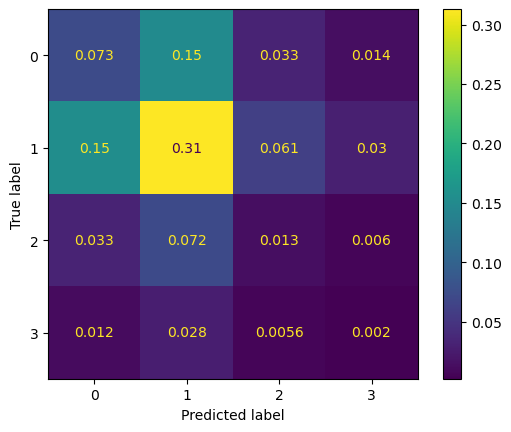

In [158]:
# confusion matrix for baseline DummyClassifier model 
ConfusionMatrixDisplay.from_predictions(y_test,base_y_pred, normalize='all')

In [159]:
print(classification_report(y_test,base_y_pred,target_names=target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.27      0.27      0.27       817
    mild anxiety       0.55      0.56      0.56      1683
moderate anxiety       0.11      0.10      0.11       373
  severe anxiety       0.04      0.04      0.04       142

        accuracy                           0.40      3015
       macro avg       0.24      0.24      0.24      3015
    weighted avg       0.40      0.40      0.40      3015



In [160]:
accuracy_score(y_test,base_y_pred)

0.40066334991708125

### Baseline Model Conclusions 

**Conclusion**: Our baseline model uses the `DummyClassifier` to estimate values. 

## Model I | Logistic Regression

In [161]:
ohe_cols = ['GADE','Game','Platform','earnings','whyplay','Gender','Work','Degree','Birthplace','Residence','Playstyle']

In [162]:
# feature selection 
non_predict_cols = ['anxiety','GAD_T']
X_1 = gamers_df.drop(columns=non_predict_cols)
y_1 = gamers_df['anxiety']

In [163]:
# label encoding our target variable 
y_1 = lab_enc.fit_transform(y_1)

In [164]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_1, y_1, test_size = 0.25,random_state=42)

#### Feature Engineering Pipelines 

In [165]:
age_pipeline = Pipeline([('agenorm',StandardScaler())])
survey_pipeline = Pipeline([('ohe_transform', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

In [166]:
age_pipeline

Pipeline(steps=[('agenorm', StandardScaler())])

In [167]:
survey_pipeline

Pipeline(steps=[('ohe_transform',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [168]:
log_ct = ColumnTransformer(
    [("obj_imputer", survey_pipeline, ['GADE','Work']), 
     ("numimputer", game_habits_pipeline, ['Hours','streams']),
     ('age_pipe', age_pipeline, ['Age']),
     ('survey_pipe', survey_pipeline, ohe_cols)
    ])
log_ct

ColumnTransformer(transformers=[('obj_imputer',
                                 Pipeline(steps=[('ohe_transform',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GADE', 'Work']),
                                ('numimputer',
                                 Pipeline(steps=[('numimputer',
                                                  IterativeImputer(initial_strategy='median',
                                                                   random_state=42))]),
                                 ['Hours', 'streams']),
                                ('age_pipe',
                                 Pipeline(steps=[('agenorm',
                                                  StandardScaler())]),
                                 ['Age']),
                                ('survey_pipe',
                                 Pipeline(steps=[('ohe_transform',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GADE', 'Game', 'Platform', 'earnings',
                                  'whyplay', 'Gender', 'Work', 'Degree',
                                  'Birthplace', 'Residence', 'Playstyle'])])

In [169]:
# logistic regression pipeline with all features standardized 
log_pipe = Pipeline([('preprocess', log_ct),
     ('model',
      LogisticRegression(random_state=42,max_iter=10000))])
log_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', LogisticRegression(max_iter=10000, random_state=42))])

In [170]:
log_pipe.fit(X1_train, y1_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', LogisticRegression(max_iter=10000, random_state=42))])

In [171]:
log_y_pred = log_pipe.predict(X1_test)

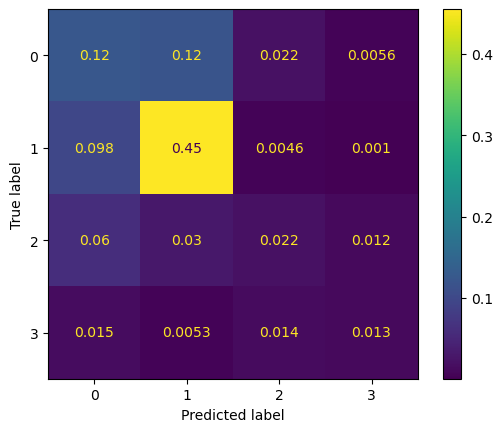

In [172]:
ConfusionMatrixDisplay.from_predictions(y1_test,log_y_pred, normalize='all')

In [173]:
# classification report for base logistic regression model w.o hyperparamter tuning 
print(classification_report(y1_test,log_y_pred, target_names=target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.42      0.46      0.44       817
    mild anxiety       0.75      0.81      0.78      1683
moderate anxiety       0.35      0.17      0.23       373
  severe anxiety       0.40      0.27      0.32       142

        accuracy                           0.61      3015
       macro avg       0.48      0.43      0.44      3015
    weighted avg       0.59      0.61      0.60      3015



In [174]:
# accuracy score for our base logistic regression model w.o hyperparameter tuning 
# base logistic regression uses all features 
accuracy_score(y1_test, log_y_pred)

0.6132669983416252

### Model Evaluation 

### Logistic Regression Hyperparameter Tuning 

In [178]:
log_pipe.steps

[('preprocess',
  ColumnTransformer(transformers=[('obj_imputer',
                                   Pipeline(steps=[('ohe_transform',
                                                    OneHotEncoder(handle_unknown='ignore',
                                                                  sparse_output=False))]),
                                   ['GADE', 'Work']),
                                  ('numimputer',
                                   Pipeline(steps=[('numimputer',
                                                    IterativeImputer(initial_strategy='median',
                                                                     random_state=42))]),
                                   ['Hours', 'streams']),
                                  ('age_pipe',
                                   Pipeline(steps=[('agenorm',
                                                    StandardScaler())]),
                                   ['Age']),
                                  ('survey

In [179]:
log_pipe_grid = {'model__penalty':['l2'],
                 'model__C': [1e-4,1e-3,1e-2,1e-1,1],
                'model__solver':['lbfgs','newton-cg']}

In [180]:
log_gs_pipe = GridSearchCV(estimator=log_pipe,
                           param_grid=log_pipe_grid

In [181]:
log_gs_pipe.fit(X1_train,y1_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('obj_imputer',
                                                                         Pipeline(steps=[('ohe_transform',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['GADE',
                                                                          'Work']),
                                                                        ('numimputer',
                                                                         Pipeline(steps=[('numimputer',
                                                                                          IterativeImputer(initial_strategy='median',
                                                                                                           random_state=42))]),
                                                                         ['Hours',
                                                                          'streams']),
                                                                        ('age_pipe...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['GADE',
                                                                          'Game',
                                                                          'Platform',
                                                                          'earnings',
                                                                          'whyplay',
                                                                          'Gender',
                                                                          'Work',
                                                                          'Degree',
                                                                          'Birthplace',
                                                                          'Residence',
                                                                          'Playstyle'])])),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42))]),
             param_grid={'model__C': [0.0001, 0.001, 0.01, 0.1, 1],
                         'model__penalty': ['l2'],
                         'model__solver': ['lbfgs', 'newton-cg']})

In [182]:
# default scoring = accuracy 
log_gs_pipe.best_score_

0.6142894181990736

In [183]:
log_gs_pipe.best_params_

{'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

In [184]:
log_best_model = log_gs_pipe.best_estimator_
best_log_ypred = log_best_model.predict(X1_test)

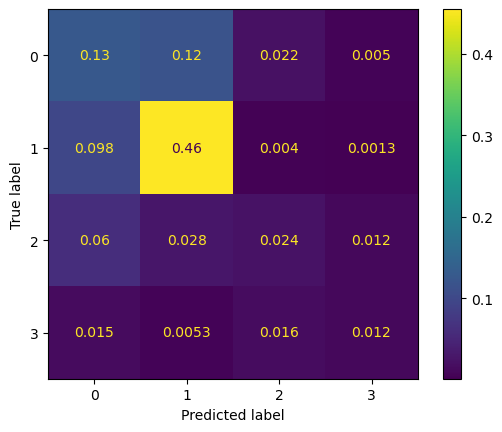

In [185]:
ConfusionMatrixDisplay.from_predictions(y1_test,best_log_ypred,normalize='all')

In [186]:
print(classification_report(y1_test,best_log_ypred, target_names=target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.42      0.47      0.45       817
    mild anxiety       0.75      0.82      0.78      1683
moderate anxiety       0.36      0.19      0.25       373
  severe anxiety       0.39      0.25      0.30       142

        accuracy                           0.62      3015
       macro avg       0.48      0.43      0.44      3015
    weighted avg       0.60      0.62      0.60      3015



In [314]:
accuracy_score(y1_test,best_log_ypred)

0.6172470978441128

**ROC_AUC_One_Vs_Rest**

In [208]:
log_gs_pipe2 = GridSearchCV(estimator=log_pipe,
                           param_grid=log_pipe_grid,scoring='roc_auc_ovr',cv=5)

In [209]:
log_gs_pipe2.fit(X1_train,y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('obj_imputer',
                                                                         Pipeline(steps=[('ohe_transform',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['GADE',
                                                                          'Work']),
                                                                        ('numimputer',
                                                                         Pipeline(steps=[('numimputer',
                                                                                          IterativeImputer(initial_strategy='median',
                                                                                                           random_state=42))]),
                                                                         ['Hours',
                                                                          'streams']),
                                                                        ('age...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['GADE',
                                                                          'Game',
                                                                          'Platform',
                                                                          'earnings',
                                                                          'whyplay',
                                                                          'Gender',
                                                                          'Work',
                                                                          'Degree',
                                                                          'Birthplace',
                                                                          'Residence',
                                                                          'Playstyle'])])),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42))]),
             param_grid={'model__C': [0.0001, 0.001, 0.01, 0.1, 1],
                         'model__penalty': ['l2'],
                         'model__solver': ['lbfgs', 'newton-cg']},
             scoring='roc_auc_ovr')

In [210]:
# scoring metric = roc_auc one vs. rest 
log_gs_pipe2.best_score_

0.780995114787963

In [211]:
log_best_model2 = log_gs_pipe2.best_estimator_
best_log_ypred2 = log_best_model2.predict(X1_test)

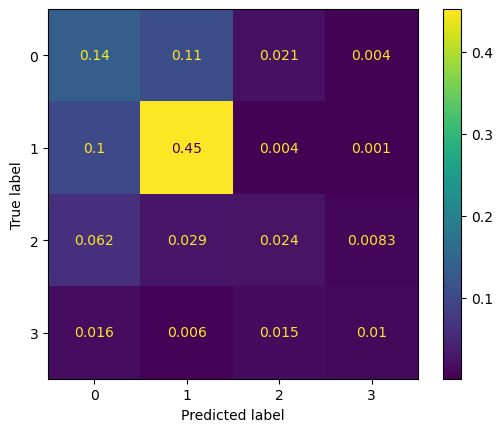

In [212]:
ConfusionMatrixDisplay.from_predictions(y1_test,best_log_ypred2,normalize='all')

In [213]:
print(classification_report(y1_test,best_log_ypred2, target_names=target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.43      0.51      0.47       817
    mild anxiety       0.76      0.81      0.78      1683
moderate anxiety       0.38      0.20      0.26       373
  severe anxiety       0.44      0.22      0.29       142

        accuracy                           0.62      3015
       macro avg       0.50      0.43      0.45      3015
    weighted avg       0.61      0.62      0.61      3015



In [313]:
accuracy_score(y1_test,best_log_ypred2)

0.6238805970149254

**F1 score**

In [214]:
# f1 score for best log_reg model using roc_auc_ovr as scoring criteria 
f1_score(y1_test,best_log_ypred2,average='weighted')

0.6095521121662114

In [215]:
log_gs_pipe3 = GridSearchCV(estimator=log_pipe,
                           param_grid=log_pipe_grid,scoring='f1_weighted',cv=5)

In [216]:
log_gs_pipe3.fit(X1_train,y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('obj_imputer',
                                                                         Pipeline(steps=[('ohe_transform',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['GADE',
                                                                          'Work']),
                                                                        ('numimputer',
                                                                         Pipeline(steps=[('numimputer',
                                                                                          IterativeImputer(initial_strategy='median',
                                                                                                           random_state=42))]),
                                                                         ['Hours',
                                                                          'streams']),
                                                                        ('age...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['GADE',
                                                                          'Game',
                                                                          'Platform',
                                                                          'earnings',
                                                                          'whyplay',
                                                                          'Gender',
                                                                          'Work',
                                                                          'Degree',
                                                                          'Birthplace',
                                                                          'Residence',
                                                                          'Playstyle'])])),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42))]),
             param_grid={'model__C': [0.0001, 0.001, 0.01, 0.1, 1],
                         'model__penalty': ['l2'],
                         'model__solver': ['lbfgs', 'newton-cg']},
             scoring='f1_weighted')

In [217]:
log_gs_pipe3.best_score_

0.599919309307288

In [218]:
log_best_model3 = log_gs_pipe3.best_estimator_
best_log_ypred3 = log_best_model3.predict(X1_test)

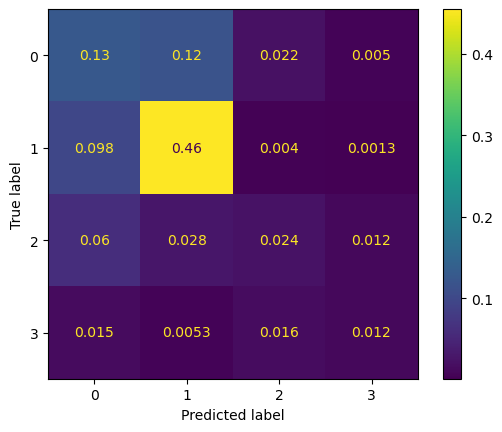

In [219]:
ConfusionMatrixDisplay.from_predictions(y1_test,best_log_ypred3,normalize='all')

In [220]:
print(classification_report(y1_test,best_log_ypred3, target_names=target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.42      0.47      0.45       817
    mild anxiety       0.75      0.82      0.78      1683
moderate anxiety       0.36      0.19      0.25       373
  severe anxiety       0.39      0.25      0.30       142

        accuracy                           0.62      3015
       macro avg       0.48      0.43      0.44      3015
    weighted avg       0.60      0.62      0.60      3015



### Comparing Different Hyperparameter Tuned Models & Metrics

In [221]:
# accuracy, roc_auc_ovr, f1_score 
log_gs_pipe.best_score_,log_gs_pipe2.best_score_,log_gs_pipe3.best_score_

(0.6142894181990736, 0.780995114787963, 0.599919309307288)

In [222]:
# best models for predicting corresponding classification metrics on test data 
log_gs_pipe.best_params_,log_gs_pipe2.best_params_,log_gs_pipe3.best_params_

({'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'},
 {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'newton-cg'},
 {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'})

**Using Balanced class weights**

In [223]:
# new params grid with class_weight 
log_pipe_grid2 = {'model__penalty':['l2'],
                 'model__C': [1e-4,1e-3,1e-2,1e-1,1],
                'model__solver':['lbfgs','newton-cg'],
                 'model__class_weight':[None,'balanced']}

In [224]:
# GridSearchCV (scoring='accuracy') with new params grid 
log_gs_pipe5 = GridSearchCV(estimator=log_pipe,
                           param_grid=log_pipe_grid2)

In [226]:
# fitting GridSearchCV pipeline with training data 
log_gs_pipe5.fit(X1_train,y1_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('obj_imputer',
                                                                         Pipeline(steps=[('ohe_transform',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['GADE',
                                                                          'Work']),
                                                                        ('numimputer',
                                                                         Pipeline(steps=[('numimputer',
                                                                                          IterativeImputer(initial_strategy='median',
                                                                                                           random_state=42))]),
                                                                         ['Hours',
                                                                          'streams']),
                                                                        ('age_pipe...
                                                                                                        sparse_output=False))]),
                                                                         ['GADE',
                                                                          'Game',
                                                                          'Platform',
                                                                          'earnings',
                                                                          'whyplay',
                                                                          'Gender',
                                                                          'Work',
                                                                          'Degree',
                                                                          'Birthplace',
                                                                          'Residence',
                                                                          'Playstyle'])])),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42))]),
             param_grid={'model__C': [0.0001, 0.001, 0.01, 0.1, 1],
                         'model__class_weight': [None, 'balanced'],
                         'model__penalty': ['l2'],
                         'model__solver': ['lbfgs', 'newton-cg']})

In [227]:
# accuracy score using different hyperparameters for class_weight
log_gs_pipe5.best_score_

0.6142894181990736

In [228]:
# GridSearchCV using roc_auc_ovr as scoring criteria 
log_gs_pipe_roc = GridSearchCV(estimator=log_pipe,
                           param_grid=log_pipe_grid2,scoring='roc_auc_ovr',cv=5)

In [229]:
# fitting GridSearchCV pipeline with training data 
log_gs_pipe_roc.fit(X1_train,y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('obj_imputer',
                                                                         Pipeline(steps=[('ohe_transform',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['GADE',
                                                                          'Work']),
                                                                        ('numimputer',
                                                                         Pipeline(steps=[('numimputer',
                                                                                          IterativeImputer(initial_strategy='median',
                                                                                                           random_state=42))]),
                                                                         ['Hours',
                                                                          'streams']),
                                                                        ('age...
                                                                         ['GADE',
                                                                          'Game',
                                                                          'Platform',
                                                                          'earnings',
                                                                          'whyplay',
                                                                          'Gender',
                                                                          'Work',
                                                                          'Degree',
                                                                          'Birthplace',
                                                                          'Residence',
                                                                          'Playstyle'])])),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42))]),
             param_grid={'model__C': [0.0001, 0.001, 0.01, 0.1, 1],
                         'model__class_weight': [None, 'balanced'],
                         'model__penalty': ['l2'],
                         'model__solver': ['lbfgs', 'newton-cg']},
             scoring='roc_auc_ovr')

In [230]:
# roc_auc_ovr score with GridSearchCV pipeline updated with class_weight parameter
log_gs_pipe_roc.best_score_

0.780995114787963

#### Hypertuning Parameters with RandomizedSearchCV 

In [234]:
# using RandomSearchCV with new grid parameters,
log_roc_random_cv = RandomizedSearchCV(estimator=log_pipe, 
                                       param_distributions = log_pipe_grid2, 
                                       scoring = 'roc_auc_ovr',
                                       n_iter = 10, 
                                       cv = 5)

In [235]:
# fitting RandomSearchCV to training data 
log_roc_random_cv.fit(X1_train,y1_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('obj_imputer',
                                                                               Pipeline(steps=[('ohe_transform',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['GADE',
                                                                                'Work']),
                                                                              ('numimputer',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42))]),
                                                                               ['Hours',
                                                                                'streams'])...
                                                                                'Game',
                                                                                'Platform',
                                                                                'earnings',
                                                                                'whyplay',
                                                                                'Gender',
                                                                                'Work',
                                                                                'Degree',
                                                                                'Birthplace',
                                                                                'Residence',
                                                                                'Playstyle'])])),
                                             ('model',
                                              LogisticRegression(max_iter=10000,
                                                                 random_state=42))]),
                   param_distributions={'model__C': [0.0001, 0.001, 0.01, 0.1,
                                                     1],
                                        'model__class_weight': [None,
                                                                'balanced'],
                                        'model__penalty': ['l2'],
                                        'model__solver': ['lbfgs',
                                                          'newton-cg']},
                   scoring='roc_auc_ovr')

In [244]:
# RandomSearchCV results with roc_auc_ovr as scoring metric 
# allows us to visually inspect each model and params 
log_randomcv_results = pd.DataFrame(log_roc_random_cv.cv_results_)
log_randomcv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__solver,param_model__penalty,param_model__class_weight,param_model__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.947739,0.632879,0.023736,0.003116,lbfgs,l2,None,0.0001,"{'model__solver': 'lbfgs', 'model__penalty': '...",0.702680,0.704465,0.650654,0.674990,0.690861,0.684730,0.020027,8
1,0.753367,0.215069,0.023536,0.002647,lbfgs,l2,balanced,0.0001,"{'model__solver': 'lbfgs', 'model__penalty': '...",0.694926,0.697467,0.634679,0.674487,0.665452,0.673402,0.022831,9
2,5.741197,0.559965,0.025133,0.004610,newton-cg,l2,None,1,"{'model__solver': 'newton-cg', 'model__penalty...",0.776299,0.762044,0.775484,0.772421,0.792282,0.775706,0.009722,2
3,3.006205,0.345473,0.030718,0.006834,newton-cg,l2,None,0.1,"{'model__solver': 'newton-cg', 'model__penalty...",0.784602,0.767308,0.778943,0.776645,0.796802,0.780860,0.009729,1
4,7.693954,1.872703,0.022938,0.002444,lbfgs,l2,balanced,0.1,"{'model__solver': 'lbfgs', 'model__penalty': '...",0.766722,0.748923,0.756542,0.759994,0.767913,0.760019,0.006964,4


In [243]:
# best parameters for LogisticRegression using roc_auc_ovr score as scoring metric 
log_roc_random_cv.best_params_

{'model__solver': 'newton-cg',
 'model__penalty': 'l2',
 'model__class_weight': None,
 'model__C': 0.1}

In [241]:
# roc_auc_ovr score using best estimator 
log_roc_random_cv.best_score_

0.7808600794584362

In [247]:
# using RandomSearchCV with f1_weighted scores as scoring criterion 
log_f1score_random_cv = RandomizedSearchCV(estimator=log_pipe, 
                                       param_distributions = log_pipe_grid2, 
                                       scoring = 'f1_weighted',
                                       n_iter = 10, 
                                       cv = 5)

In [248]:
# fitting RandomSearchCV to training data 
log_f1score_random_cv.fit(X1_train,y1_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('obj_imputer',
                                                                               Pipeline(steps=[('ohe_transform',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['GADE',
                                                                                'Work']),
                                                                              ('numimputer',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42))]),
                                                                               ['Hours',
                                                                                'streams'])...
                                                                                'Game',
                                                                                'Platform',
                                                                                'earnings',
                                                                                'whyplay',
                                                                                'Gender',
                                                                                'Work',
                                                                                'Degree',
                                                                                'Birthplace',
                                                                                'Residence',
                                                                                'Playstyle'])])),
                                             ('model',
                                              LogisticRegression(max_iter=10000,
                                                                 random_state=42))]),
                   param_distributions={'model__C': [0.0001, 0.001, 0.01, 0.1,
                                                     1],
                                        'model__class_weight': [None,
                                                                'balanced'],
                                        'model__penalty': ['l2'],
                                        'model__solver': ['lbfgs',
                                                          'newton-cg']},
                   scoring='f1_weighted')

In [250]:
log_f1score_random_cv.best_params_

{'model__solver': 'newton-cg',
 'model__penalty': 'l2',
 'model__class_weight': None,
 'model__C': 0.1}

In [251]:
log_f1score_random_cv.best_score_

0.5992847072131792

### Model Evaluation Conclusions

**Questions:** 
- What conclusions can we draw based on hyperparameter tuning?
- What is our best model given different scoring criterions?

## Model II | Decision Trees 

In [103]:
# separating our target and predictor variables 
X_2 = gamers_df.drop(columns=non_predict_cols)
y_2 = gamers_df['anxiety']

In [104]:
# label encoding our target variable 
y_2 = lab_enc.fit_transform(y_2)

In [105]:
# splitting our data into training and test set 
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, y_2, test_size = 0.25,random_state=42)

In [106]:
dt_ct = ColumnTransformer(
    [("obj_imputer", survey_pipeline, ['GADE','Work']), 
     ("numimputer", game_habits_pipeline, ['Hours','streams']),
     ('age_pipe', age_pipeline, ['Age']),
     ('survey_pipe', survey_pipeline, ohe_cols)
    ])
dt_ct

ColumnTransformer(transformers=[('obj_imputer',
                                 Pipeline(steps=[('ohe_transform',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GADE', 'Work']),
                                ('numimputer',
                                 Pipeline(steps=[('numimputer',
                                                  IterativeImputer(initial_strategy='median',
                                                                   random_state=42))]),
                                 ['Hours', 'streams']),
                                ('age_pipe',
                                 Pipeline(steps=[('agenorm',
                                                  StandardScaler())]),
                                 ['Age']),
                                ('survey_pipe',
                                 Pipeline(steps=[('ohe_transform',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GADE', 'Game', 'Platform', 'earnings',
                                  'whyplay', 'Gender', 'Work', 'Degree',
                                  'Birthplace', 'Residence', 'Playstyle'])])

In [107]:
# DecisionTree pipeline with all features standardized 
dt_pipe = Pipeline([('preprocess', dt_ct),
     ('model',
      DecisionTreeClassifier(random_state=42))])
dt_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', DecisionTreeClassifier(random_state=42))])

In [108]:
dt_pipe.fit(X2_train,y2_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', DecisionTreeClassifier(random_state=42))])

In [109]:
dt_y_pred = dt_pipe.predict(X2_test)

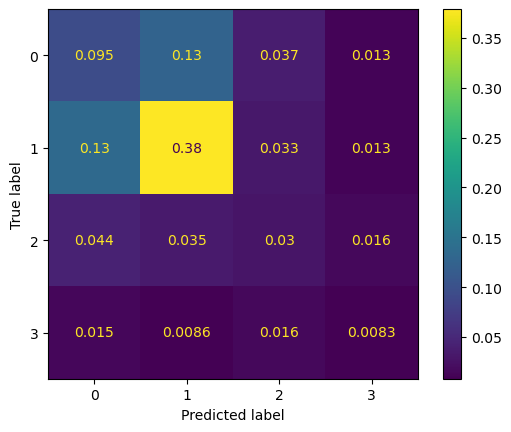

In [110]:
ConfusionMatrixDisplay.from_predictions(y2_test,dt_y_pred, normalize='all')

In [316]:
print(classification_report(y2_test,dt_y_pred, target_names=target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.33      0.35      0.34       817
    mild anxiety       0.69      0.68      0.68      1683
moderate anxiety       0.26      0.24      0.25       373
  severe anxiety       0.17      0.18      0.17       142

        accuracy                           0.51      3015
       macro avg       0.36      0.36      0.36      3015
    weighted avg       0.51      0.51      0.51      3015



In [317]:
accuracy_score(y2_test,dt_y_pred)

0.5111111111111111

## Model Evaluation 

### Decision Tree  Hyperparameter Tuning 

In [275]:
# DecisionTreeClassifier parameters grid 
dt_pipe_grid = {'model__max_depth':[2,4,6,8,10],
                 'model__min_samples_split': [2,10,100,500,1000],
                'model__min_samples_leaf':[1,10,100,500,1000]}

In [276]:
# using RandomSearchCV with new grid parameters,
dt_random_cv = RandomizedSearchCV(estimator = dt_pipe, 
                                       param_distributions = dt_pipe_grid,
                                       n_iter = 10, 
                                       cv = 5)

In [277]:
dt_random_cv.fit(X2_train,y2_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('obj_imputer',
                                                                               Pipeline(steps=[('ohe_transform',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['GADE',
                                                                                'Work']),
                                                                              ('numimputer',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42))]),
                                                                               ['Hours',
                                                                                'streams'])...
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['GADE',
                                                                                'Game',
                                                                                'Platform',
                                                                                'earnings',
                                                                                'whyplay',
                                                                                'Gender',
                                                                                'Work',
                                                                                'Degree',
                                                                                'Birthplace',
                                                                                'Residence',
                                                                                'Playstyle'])])),
                                             ('model',
                                              DecisionTreeClassifier(random_state=42))]),
                   param_distributions={'model__max_depth': [2, 4, 6, 8, 10],
                                        'model__min_samples_leaf': [1, 10, 100,
                                                                    500, 1000],
                                        'model__min_samples_split': [2, 10, 100,
                                                                     500,
                                                                     1000]})

In [283]:
# accuracy score of best Decision Tree Model with best params 
dt_random_cv.best_score_, dt_random_cv.best_params_

(0.6119665316485419,
 {'model__min_samples_split': 100,
  'model__min_samples_leaf': 100,
  'model__max_depth': 10})

In [318]:
dt_random_cv.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('age...
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=100,
                                        min_samples_split=100,
                                        random_state=42))])

In [320]:
dt_best_model = dt_random_cv.best_estimator_
best_dt_preds = dt_best_model.predict(X2_test)

In [321]:
# classification report using the most accurate DecisionTreeClassifier model 
print(classification_report(y2_test,best_dt_preds,target_names=target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.43      0.53      0.47       817
    mild anxiety       0.78      0.79      0.79      1683
moderate anxiety       0.36      0.19      0.25       373
  severe anxiety       0.36      0.32      0.34       142

        accuracy                           0.62      3015
       macro avg       0.48      0.45      0.46      3015
    weighted avg       0.61      0.62      0.61      3015



In [287]:
# RandomizedSearchCV with roc_auc_ovr as scoring criteria 
dt_roc_random_cv = RandomizedSearchCV(estimator = dt_pipe, 
                                       param_distributions = dt_pipe_grid,
                                       n_iter = 10, 
                                       scoring='roc_auc_ovr', 
                                       cv = 5)

In [288]:
dt_roc_random_cv.fit(X2_train,y2_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('obj_imputer',
                                                                               Pipeline(steps=[('ohe_transform',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['GADE',
                                                                                'Work']),
                                                                              ('numimputer',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42))]),
                                                                               ['Hours',
                                                                                'streams'])...
                                                                                                              sparse_output=False))]),
                                                                               ['GADE',
                                                                                'Game',
                                                                                'Platform',
                                                                                'earnings',
                                                                                'whyplay',
                                                                                'Gender',
                                                                                'Work',
                                                                                'Degree',
                                                                                'Birthplace',
                                                                                'Residence',
                                                                                'Playstyle'])])),
                                             ('model',
                                              DecisionTreeClassifier(random_state=42))]),
                   param_distributions={'model__max_depth': [2, 4, 6, 8, 10],
                                        'model__min_samples_leaf': [1, 10, 100,
                                                                    500, 1000],
                                        'model__min_samples_split': [2, 10, 100,
                                                                     500,
                                                                     1000]},
                   scoring='roc_auc_ovr')

In [289]:
# roc_auc_ovr score of best Decision Tree Model 
dt_roc_random_cv.best_score_, dt_roc_random_cv.best_params_

(0.7755704900212207,
 {'model__min_samples_split': 100,
  'model__min_samples_leaf': 100,
  'model__max_depth': 8})

In [324]:
dt_best_roc_model = dt_roc_random_cv.best_estimator_
best_dt_roc_preds = dt_best_roc_model.predict(X2_test)

In [325]:
print(classification_report(y2_test,best_dt_roc_preds,target_names=target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.43      0.55      0.48       817
    mild anxiety       0.79      0.77      0.78      1683
moderate anxiety       0.36      0.19      0.25       373
  severe anxiety       0.36      0.32      0.34       142

        accuracy                           0.62      3015
       macro avg       0.48      0.46      0.46      3015
    weighted avg       0.62      0.62      0.61      3015



In [290]:
# RandomizedSearchCV with f1_weighted as scoring criteria
dt_f1_random_cv = RandomizedSearchCV(estimator = dt_pipe, 
                                       param_distributions = dt_pipe_grid,
                                       n_iter = 10, 
                                       scoring='f1_weighted', 
                                       cv = 5)

In [291]:
dt_f1_random_cv.fit(X2_train,y2_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('obj_imputer',
                                                                               Pipeline(steps=[('ohe_transform',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['GADE',
                                                                                'Work']),
                                                                              ('numimputer',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42))]),
                                                                               ['Hours',
                                                                                'streams'])...
                                                                                                              sparse_output=False))]),
                                                                               ['GADE',
                                                                                'Game',
                                                                                'Platform',
                                                                                'earnings',
                                                                                'whyplay',
                                                                                'Gender',
                                                                                'Work',
                                                                                'Degree',
                                                                                'Birthplace',
                                                                                'Residence',
                                                                                'Playstyle'])])),
                                             ('model',
                                              DecisionTreeClassifier(random_state=42))]),
                   param_distributions={'model__max_depth': [2, 4, 6, 8, 10],
                                        'model__min_samples_leaf': [1, 10, 100,
                                                                    500, 1000],
                                        'model__min_samples_split': [2, 10, 100,
                                                                     500,
                                                                     1000]},
                   scoring='f1_weighted')

In [292]:
# f1_weighted score of best Decision Tree Model 
dt_f1_random_cv.best_score_, dt_f1_random_cv.best_params_

(0.614618276481781,
 {'model__min_samples_split': 100,
  'model__min_samples_leaf': 100,
  'model__max_depth': 6})

## Model III | Random Forest 

In [112]:
# separating our target and predictor variables 
X_3 = gamers_df.drop(columns=non_predict_cols)
y_3 = gamers_df['anxiety']

In [113]:
# label encoding our target variable 
y_3 = lab_enc.fit_transform(y_3)

In [114]:
# splitting our data into training and test set 
X3_train, X3_test, y3_train, y3_test = train_test_split(X_3, y_3, test_size = 0.25,random_state=42)

In [115]:
rf_ct = ColumnTransformer(
    [("obj_imputer", survey_pipeline, ['GADE','Work']), 
     ("numimputer", game_habits_pipeline, ['Hours','streams']),
     ('age_pipe', age_pipeline, ['Age']),
     ('survey_pipe', survey_pipeline, ohe_cols)
    ])
rf_ct

ColumnTransformer(transformers=[('obj_imputer',
                                 Pipeline(steps=[('ohe_transform',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GADE', 'Work']),
                                ('numimputer',
                                 Pipeline(steps=[('numimputer',
                                                  IterativeImputer(initial_strategy='median',
                                                                   random_state=42))]),
                                 ['Hours', 'streams']),
                                ('age_pipe',
                                 Pipeline(steps=[('agenorm',
                                                  StandardScaler())]),
                                 ['Age']),
                                ('survey_pipe',
                                 Pipeline(steps=[('ohe_transform',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GADE', 'Game', 'Platform', 'earnings',
                                  'whyplay', 'Gender', 'Work', 'Degree',
                                  'Birthplace', 'Residence', 'Playstyle'])])

In [116]:
# RandomForest pipeline with all features standardized 
rf_pipe = Pipeline([('preprocess', rf_ct),
     ('model',
      RandomForestClassifier(random_state=42))])
rf_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [117]:
rf_pipe.fit(X3_train, y3_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [118]:
rf_y_pred = rf_pipe.predict(X3_test)

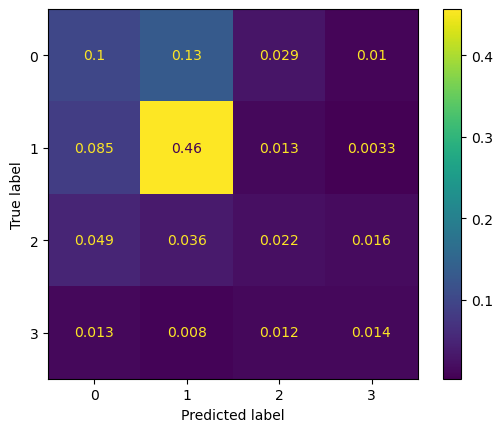

In [119]:
ConfusionMatrixDisplay.from_predictions(y3_test, rf_y_pred, normalize='all')

In [120]:
print(classification_report(y3_test, rf_y_pred, target_names = target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.40      0.37      0.39       817
    mild anxiety       0.72      0.82      0.77      1683
moderate anxiety       0.29      0.18      0.22       373
  severe anxiety       0.32      0.29      0.30       142

        accuracy                           0.59      3015
       macro avg       0.43      0.41      0.42      3015
    weighted avg       0.56      0.59      0.57      3015



### Model Evaluation 

### Random Forest Hyperparameter Tuning 

In [294]:
# RandomForestClassifier parameters grid 
rf_pipe_grid = {'model__n_estimators':[50,100,150,200,250],
                'model__max_features':['sqrt','log2'],
                'model__min_samples_split': [2,10,100,500,1000],
                'model__min_samples_leaf':[1,10,100,500,1000]}

In [295]:
# using RandomizedSearchCV with new grid parameters,
rf_random_cv = RandomizedSearchCV(estimator = rf_pipe, 
                                       param_distributions = rf_pipe_grid,
                                       n_iter = 10, 
                                       cv = 5)

In [296]:
# fitting RandomizedSearchCV with training data 
rf_random_cv.fit(X3_train,y3_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('obj_imputer',
                                                                               Pipeline(steps=[('ohe_transform',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['GADE',
                                                                                'Work']),
                                                                              ('numimputer',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42))]),
                                                                               ['Hours',
                                                                                'streams'])...
                                                                                'Game',
                                                                                'Platform',
                                                                                'earnings',
                                                                                'whyplay',
                                                                                'Gender',
                                                                                'Work',
                                                                                'Degree',
                                                                                'Birthplace',
                                                                                'Residence',
                                                                                'Playstyle'])])),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': [1, 10, 100,
                                                                    500, 1000],
                                        'model__min_samples_split': [2, 10, 100,
                                                                     500,
                                                                     1000],
                                        'model__n_estimators': [50, 100, 150,
                                                                200, 250]})

In [328]:
rf_random_cv.best_params_

{'model__n_estimators': 250,
 'model__min_samples_split': 10,
 'model__min_samples_leaf': 10,
 'model__max_features': 'sqrt'}

In [299]:
# accuracy score and best params side-by-side 
rf_random_cv.best_score_,rf_random_cv.best_params_

(0.6218084846172285,
 {'model__n_estimators': 250,
  'model__min_samples_split': 10,
  'model__min_samples_leaf': 10,
  'model__max_features': 'sqrt'})

In [300]:
# calculating predictions based on best parameters for accuracy 
best_acc_rf_preds = rf_random_cv.predict(X3_test)

In [305]:
# precision score on test set data 
precision_score(y3_test,best_acc_rf_preds,average='weighted')

0.6084904099871997

In [307]:
# f1 score on test set data 
f1_score(y3_test,best_acc_rf_preds,average='weighted')

0.611985235978669

In [301]:
print(classification_report(y3_test, best_acc_rf_preds, target_names = target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.43      0.48      0.46       817
    mild anxiety       0.76      0.81      0.79      1683
moderate anxiety       0.38      0.23      0.29       373
  severe anxiety       0.39      0.23      0.29       142

        accuracy                           0.62      3015
       macro avg       0.49      0.44      0.45      3015
    weighted avg       0.61      0.62      0.61      3015



## Model IV | Naive Bayes

In [121]:
# separating our target and predictor variables 
X_4 = gamers_df.drop(columns=non_predict_cols)
y_4 = gamers_df['anxiety']

In [122]:
# label encoding our target variable 
y_4 = lab_enc.fit_transform(y_4)

In [123]:
# splitting our data into training and test set 
X4_train, X4_test, y4_train, y4_test = train_test_split(X_4, y_4, test_size = 0.25,random_state=42)

In [124]:
nb_ct = ColumnTransformer(
    [("obj_imputer", survey_pipeline, ['GADE','Work']), 
     ("numimputer", game_habits_pipeline, ['Hours','streams']),
     ('age_pipe', age_pipeline, ['Age']),
     ('survey_pipe', survey_pipeline, ohe_cols)
    ])
nb_ct

ColumnTransformer(transformers=[('obj_imputer',
                                 Pipeline(steps=[('ohe_transform',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GADE', 'Work']),
                                ('numimputer',
                                 Pipeline(steps=[('numimputer',
                                                  IterativeImputer(initial_strategy='median',
                                                                   random_state=42))]),
                                 ['Hours', 'streams']),
                                ('age_pipe',
                                 Pipeline(steps=[('agenorm',
                                                  StandardScaler())]),
                                 ['Age']),
                                ('survey_pipe',
                                 Pipeline(steps=[('ohe_transform',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GADE', 'Game', 'Platform', 'earnings',
                                  'whyplay', 'Gender', 'Work', 'Degree',
                                  'Birthplace', 'Residence', 'Playstyle'])])

In [125]:
# Naive Bayes Classification pipeline with all features standardized 
nb_pipe = Pipeline([('preprocess', nb_ct),
     ('model',
      GaussianNB())])
nb_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', GaussianNB())])

In [126]:
nb_pipe.fit(X4_train,y4_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', GaussianNB())])

In [127]:
nb_y_pred = nb_pipe.predict(X4_test)

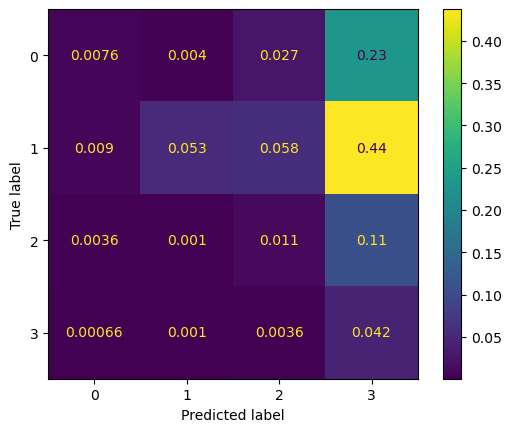

In [128]:
ConfusionMatrixDisplay.from_predictions(y4_test, nb_y_pred, normalize='all')

In [129]:
print(classification_report(y4_test, nb_y_pred, target_names = target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.37      0.03      0.05       817
    mild anxiety       0.90      0.10      0.17      1683
moderate anxiety       0.11      0.09      0.10       373
  severe anxiety       0.05      0.89      0.10       142

        accuracy                           0.11      3015
       macro avg       0.36      0.28      0.11      3015
    weighted avg       0.62      0.11      0.13      3015



#### Quadratic Discriminat Analysis (QDA)

In [331]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda_pipe = Pipeline([('preprocess', nb_ct),
     ('model',
      QuadraticDiscriminantAnalysis())])
qda_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', QuadraticDiscriminantAnalysis())])

In [332]:
qda_pipe.fit(X4_train,y4_train)

C:\Users\Kevin\anaconda3\envs\flatiron-project\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', QuadraticDiscriminantAnalysis())])

In [334]:
qda_y_pred = qda_pipe.predict(X4_test)

In [335]:
print(classification_report(y4_test, qda_y_pred, target_names = target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.28      0.02      0.03       817
    mild anxiety       0.38      0.01      0.02      1683
moderate anxiety       0.11      0.08      0.09       373
  severe anxiety       0.05      0.91      0.09       142

        accuracy                           0.06      3015
       macro avg       0.20      0.25      0.06      3015
    weighted avg       0.30      0.06      0.03      3015



### Model Evaluation 

## Model V | K-Nearest Neighbors Classification 

In [341]:
# separating our target and predictor variables 
X_5 = gamers_df.drop(columns=non_predict_cols)
y_5 = gamers_df['anxiety']

In [342]:
# label encoding our target variable 
y_5 = lab_enc.fit_transform(y_5)

In [343]:
# splitting our data into training and test set 
X5_train, X5_test, y5_train, y5_test = train_test_split(X_5, y_5, test_size = 0.25,random_state=42)

In [344]:
knn_ct = ColumnTransformer(
    [("obj_imputer", survey_pipeline, ['GADE','Work']), 
     ("numimputer", game_habits_pipeline, ['Hours','streams']),
     ('age_pipe', age_pipeline, ['Age']),
     ('survey_pipe', survey_pipeline, ohe_cols)
    ])
knn_ct

ColumnTransformer(transformers=[('obj_imputer',
                                 Pipeline(steps=[('ohe_transform',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GADE', 'Work']),
                                ('numimputer',
                                 Pipeline(steps=[('numimputer',
                                                  IterativeImputer(initial_strategy='median',
                                                                   random_state=42))]),
                                 ['Hours', 'streams']),
                                ('age_pipe',
                                 Pipeline(steps=[('agenorm',
                                                  StandardScaler())]),
                                 ['Age']),
                                ('survey_pipe',
                                 Pipeline(steps=[('ohe_transform',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['GADE', 'Game', 'Platform', 'earnings',
                                  'whyplay', 'Gender', 'Work', 'Degree',
                                  'Birthplace', 'Residence', 'Playstyle'])])

In [345]:
# K-Nearest Neighbors Classification pipeline with all features standardized 
knn_pipe = Pipeline([('preprocess', knn_ct),
     ('model',
      KNeighborsClassifier())])
knn_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', KNeighborsClassifier())])

In [346]:
knn_pipe.fit(X5_train,y5_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('obj_imputer',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Work']),
                                                 ('numimputer',
                                                  Pipeline(steps=[('numimputer',
                                                                   IterativeImputer(initial_strategy='median',
                                                                                    random_state=42))]),
                                                  ['Hours', 'streams']),
                                                 ('age_pipe',
                                                  Pipeline(steps=[('agenorm',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('survey_pipe',
                                                  Pipeline(steps=[('ohe_transform',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['GADE', 'Game', 'Platform',
                                                   'earnings', 'whyplay',
                                                   'Gender', 'Work', 'Degree',
                                                   'Birthplace', 'Residence',
                                                   'Playstyle'])])),
                ('model', KNeighborsClassifier())])

In [347]:
knn_y_pred = knn_pipe.predict(X5_test)

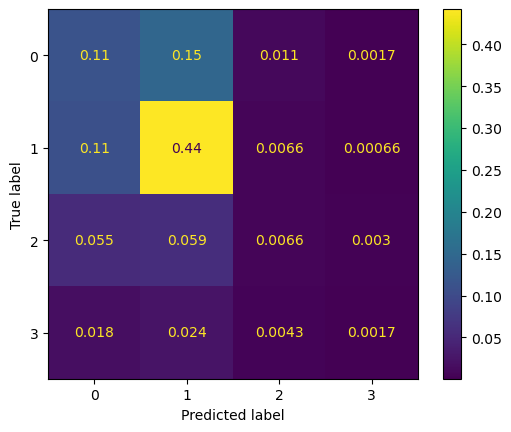

In [348]:
ConfusionMatrixDisplay.from_predictions(y5_test, knn_y_pred, normalize='all')

In [349]:
print(classification_report(y5_test, knn_y_pred, target_names = target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.38      0.42      0.40       817
    mild anxiety       0.66      0.79      0.72      1683
moderate anxiety       0.24      0.05      0.09       373
  severe anxiety       0.24      0.04      0.06       142

        accuracy                           0.56      3015
       macro avg       0.38      0.32      0.32      3015
    weighted avg       0.51      0.56      0.52      3015



### Model Evaluation 

### K-Nearest Neighbors Hyperparameter Tuning 

In [ ]:
KNeighborsClassifier()

In [351]:
# KNearestNeighbors parameters grid 
knn_pipe_grid = {'model__n_neighbors':[3, 11, 15],
                 'model__p': [1, 2]}

In [354]:
# using RandomizedSearchCV with new grid parameters,
knn_random_cv = RandomizedSearchCV(estimator = knn_pipe, 
                                       param_distributions = knn_pipe_grid,
                                       n_iter = 6, 
                                       cv = 5)

In [355]:
knn_random_cv.fit(X5_train,y5_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('obj_imputer',
                                                                               Pipeline(steps=[('ohe_transform',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['GADE',
                                                                                'Work']),
                                                                              ('numimputer',
                                                                               Pipeline(steps=[('numimputer',
                                                                                                IterativeImputer(initial_strategy='median',
                                                                                                                 random_state=42))]),
                                                                               ['Hours',
                                                                                'streams'])...
                                                                                                StandardScaler())]),
                                                                               ['Age']),
                                                                              ('survey_pipe',
                                                                               Pipeline(steps=[('ohe_transform',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['GADE',
                                                                                'Game',
                                                                                'Platform',
                                                                                'earnings',
                                                                                'whyplay',
                                                                                'Gender',
                                                                                'Work',
                                                                                'Degree',
                                                                                'Birthplace',
                                                                                'Residence',
                                                                                'Playstyle'])])),
                                             ('model',
                                              KNeighborsClassifier())]),
                   n_iter=6,
                   param_distributions={'model__n_neighbors': [3, 11, 15],
                                        'model__p': [1, 2]})

In [357]:
# calculating predictions based on best parameters for accuracy 
best_acc_knn_preds = knn_random_cv.predict(X5_test)

In [358]:
print(classification_report(y5_test, best_acc_knn_preds, target_names = target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.38      0.36      0.37       817
    mild anxiety       0.65      0.83      0.73      1683
moderate anxiety       0.26      0.05      0.09       373
  severe anxiety       0.45      0.04      0.07       142

        accuracy                           0.57      3015
       macro avg       0.43      0.32      0.31      3015
    weighted avg       0.52      0.57      0.52      3015



### Conclusion

**Thoughts**